## Mooring Report, Lake Zug, 2026.01.28

LZN, LZW, LZE moorings retrieval.

In [2]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import dolfyn as dlfn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


### LZN

Lost one (deepest) thermistor.

In [3]:
lake = 'Zugersee'
location = 'LZN'
year = '2026'
date = '20260114'

t_start = '2025-11-06'
t_end = '2026-01-27'

In [4]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

#### ADCP

In [5]:
adcps

[{'instrument': 'adcp', 'serial_id': '420', 'mab': 1.3, 'comments': 'up'}]

In [6]:
adcp = adcps[0]

serial_id = adcp['serial_id']
areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
fpath = areader.locate_data_file('L0')
ds = areader.load_from_L0(fpath)
ds = areader.range_to_depth(ds)
ds = areader.run_qa(ds)
print(areader.depth)
ds = ds.sel(time=slice(t_start, t_end))


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZN/L0\3U420000.000 ...
137.77456665039062


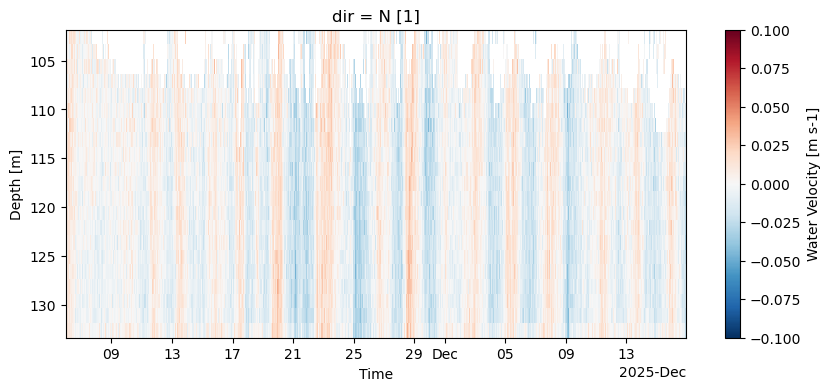

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))

ds.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Depth [m]')
ax.invert_yaxis()
plt.show()

#### Oxygen Loggers

Subtract minimum value for each timeseries (294627 minimum not anoxic).  Fix clock offset, 294627 first sample at 11:46, picture shows 11:44:01 at 1156, set t0 = 11:58.  797278 first sample at 5:15 (on 13.3.2025), picture shows 5:13:38 at 11:58, set t0 = 12:00.  

In [32]:
oxygen_loggers

[{'instrument': 'minidot', 'serial_id': '917554', 'mab': 25, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '294627', 'mab': 15, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '797278', 'mab': 5, 'comments': ''}]

In [34]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    ds = oreader.load_from_L0()

    # fix clock offset
    if serial_id == '797278':
        t0 = pd.Timestamp('2025-10-24 12:00:00')
        dt = t0 - ds.time.values[0]
        ds = ds.assign_coords(time=ds.time + dt)
    elif serial_id == '294627':
        t0 = pd.Timestamp('2025-10-24 11:58:00')
        dt = t0 - ds.time.values[0]
        ds = ds.assign_coords(time=ds.time + dt)

    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] -= ds['d_oxygen_conc'].min().item()    # subtract minimum
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain[:-1])

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


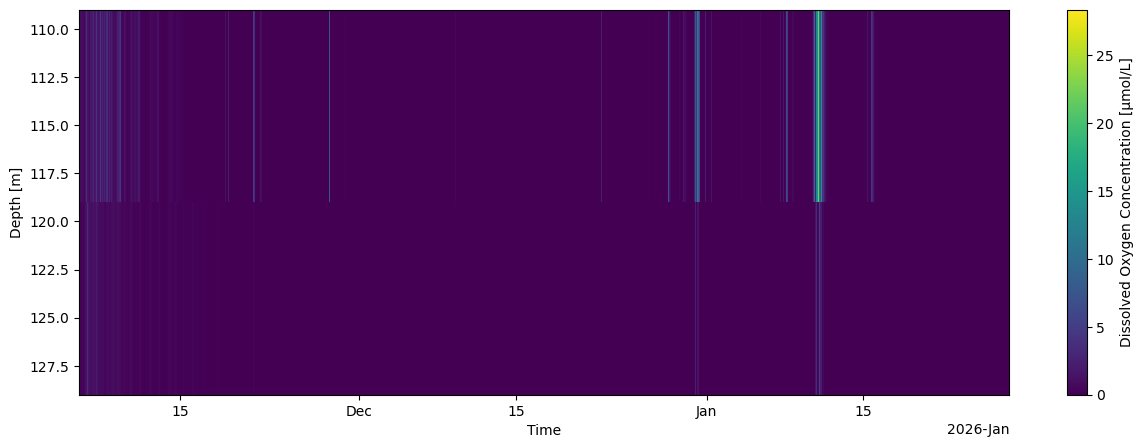

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

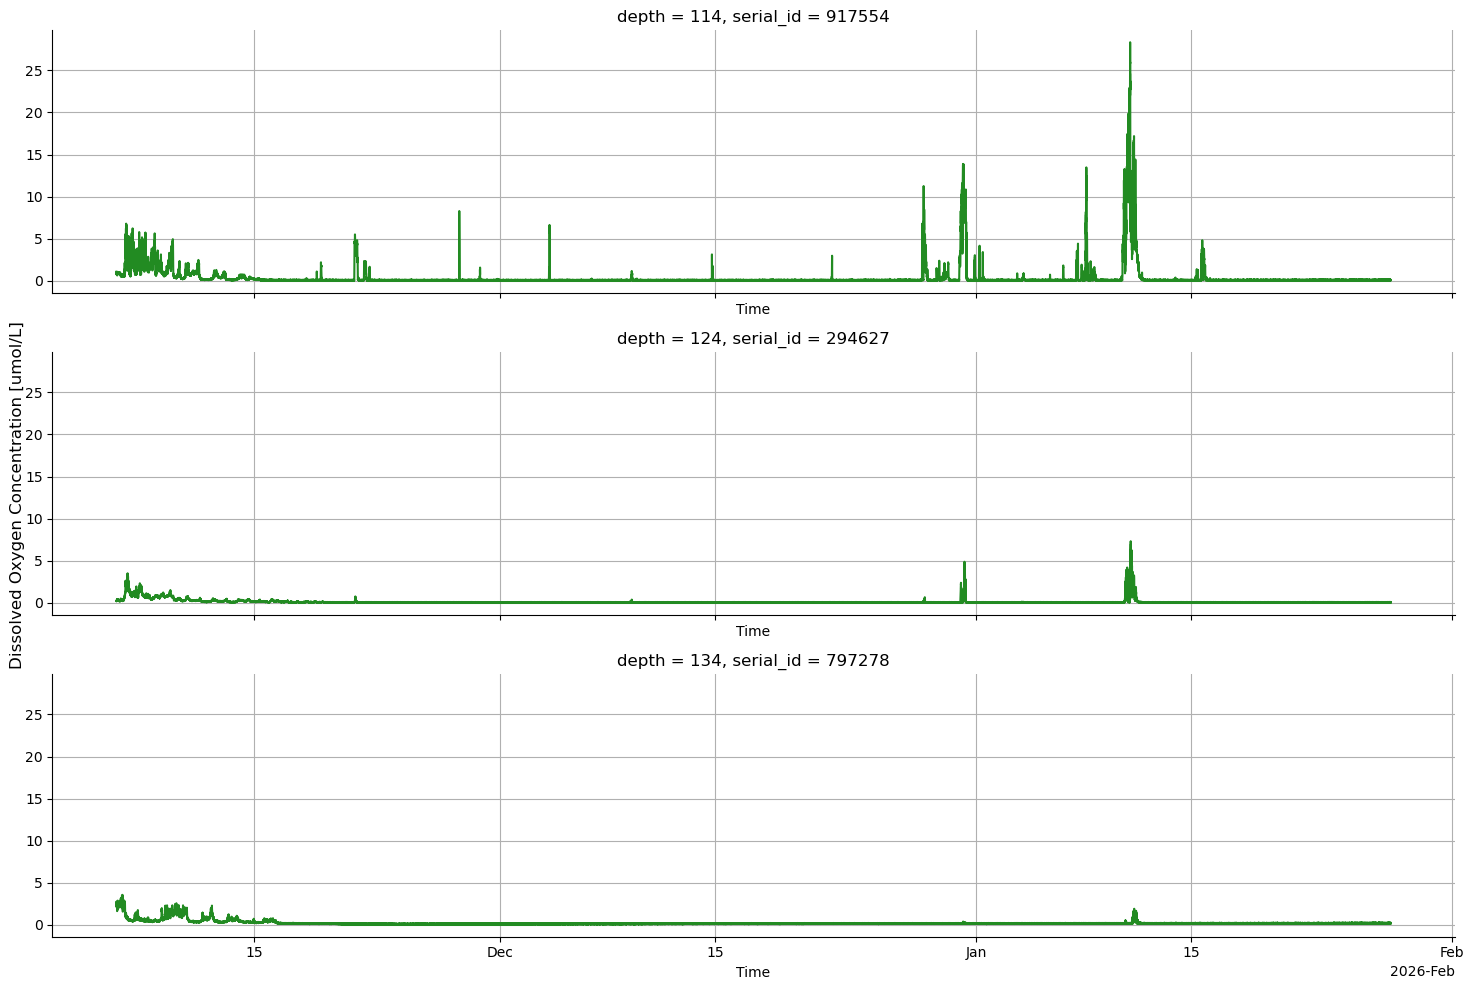

In [36]:
fig, ax = plt.subplots(nrows=len(ds_chain), ncols=1, figsize=(15, 10), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    #ax[i].plot(np.arange(len(d['d_oxygen_conc'][20000:-1000])), d['d_oxygen_conc'][20000:-1000], color='forestgreen')
    d['d_oxygen_conc'].plot(color='forestgreen', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Dissolved Oxygen Concentration [umol/L]')
plt.tight_layout()
plt.show()

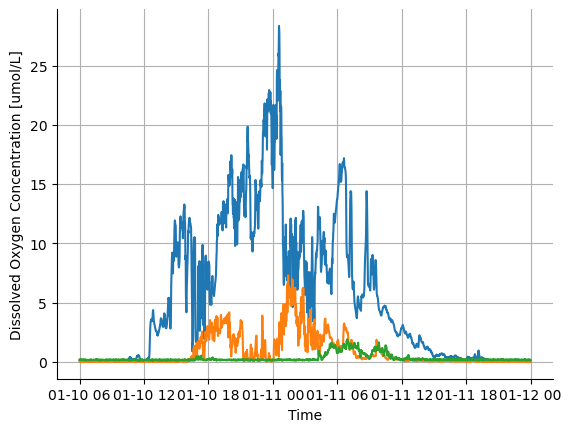

In [39]:
fig, ax = plt.subplots()

for i, d in enumerate(ds_chain):
    dat = d.sel(time=slice('2026-01-10 06:00', '2026-01-11'))
    ax.plot(dat['time'], dat['d_oxygen_conc'])
    #d['d_oxygen_conc'].sel(time=slice('2026-01-10 06:00', '2026-01-11')).plot(ax=ax)

ax.set_xlabel('Time')
ax.set_ylabel('Dissolved Oxygen Concentration [umol/L]')

ax.grid(True)
ax.spines[['right', 'top']].set_visible(False)

plt.show()

#### Thermistors

205533 error with opening file: `Unsupported RSK type: processing`.  First RSK file I downloaded after retrieval.

Trying again with same instrument on test file, no error.  Ok to redeploy insturment.

In [50]:
thermistors

[{'instrument': 'rbr_temp', 'serial_id': '200565', 'mab': 85, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '203319', 'mab': 80, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205524', 'mab': 75, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '209290', 'mab': 70, 'comments': ''},
 {'instrument': 'rbr_temp',
  'serial_id': '205514',
  'mab': 65,
  'comments': '205519'},
 {'instrument': 'rbr_temp', 'serial_id': '205520', 'mab': 60, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205537', 'mab': 55, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '209292', 'mab': 50, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205515', 'mab': 45, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205533', 'mab': 40, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '209297', 'mab': 35, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205525', 'mab': 30, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id':

In [34]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    try:
        treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
        ds = treader.load_from_L0()
        ds = ds.sel(time=slice(t_start, t_end))
        ds_chain.append(ds)
    except Exception as e:
        print(f"Could not load data for thermistor {serial_id}: {e}")

ds_temp = mreader.create_instrument_chain(ds_chain)

Could not load data for thermistor 205533: Unsupported RSK type: processing
Could not load data for thermistor 200578: Could not find single data file for 200578.


C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


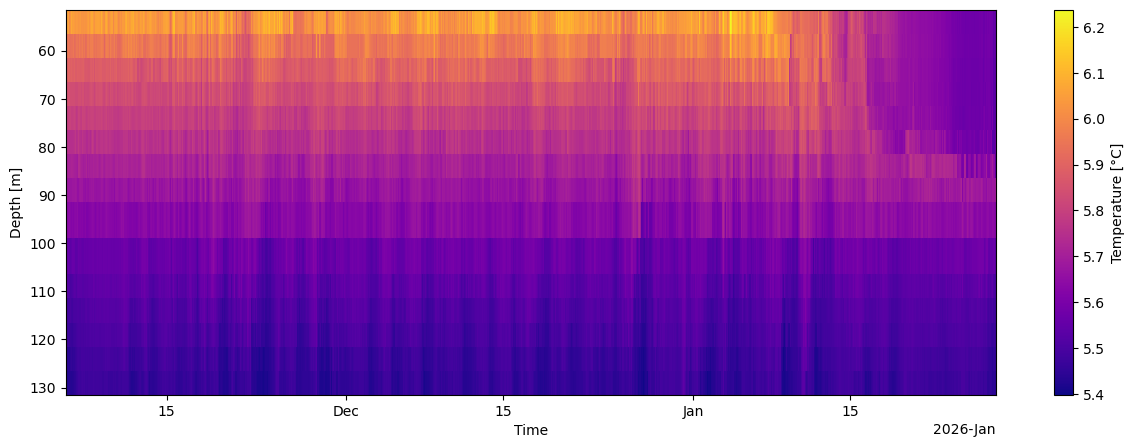

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

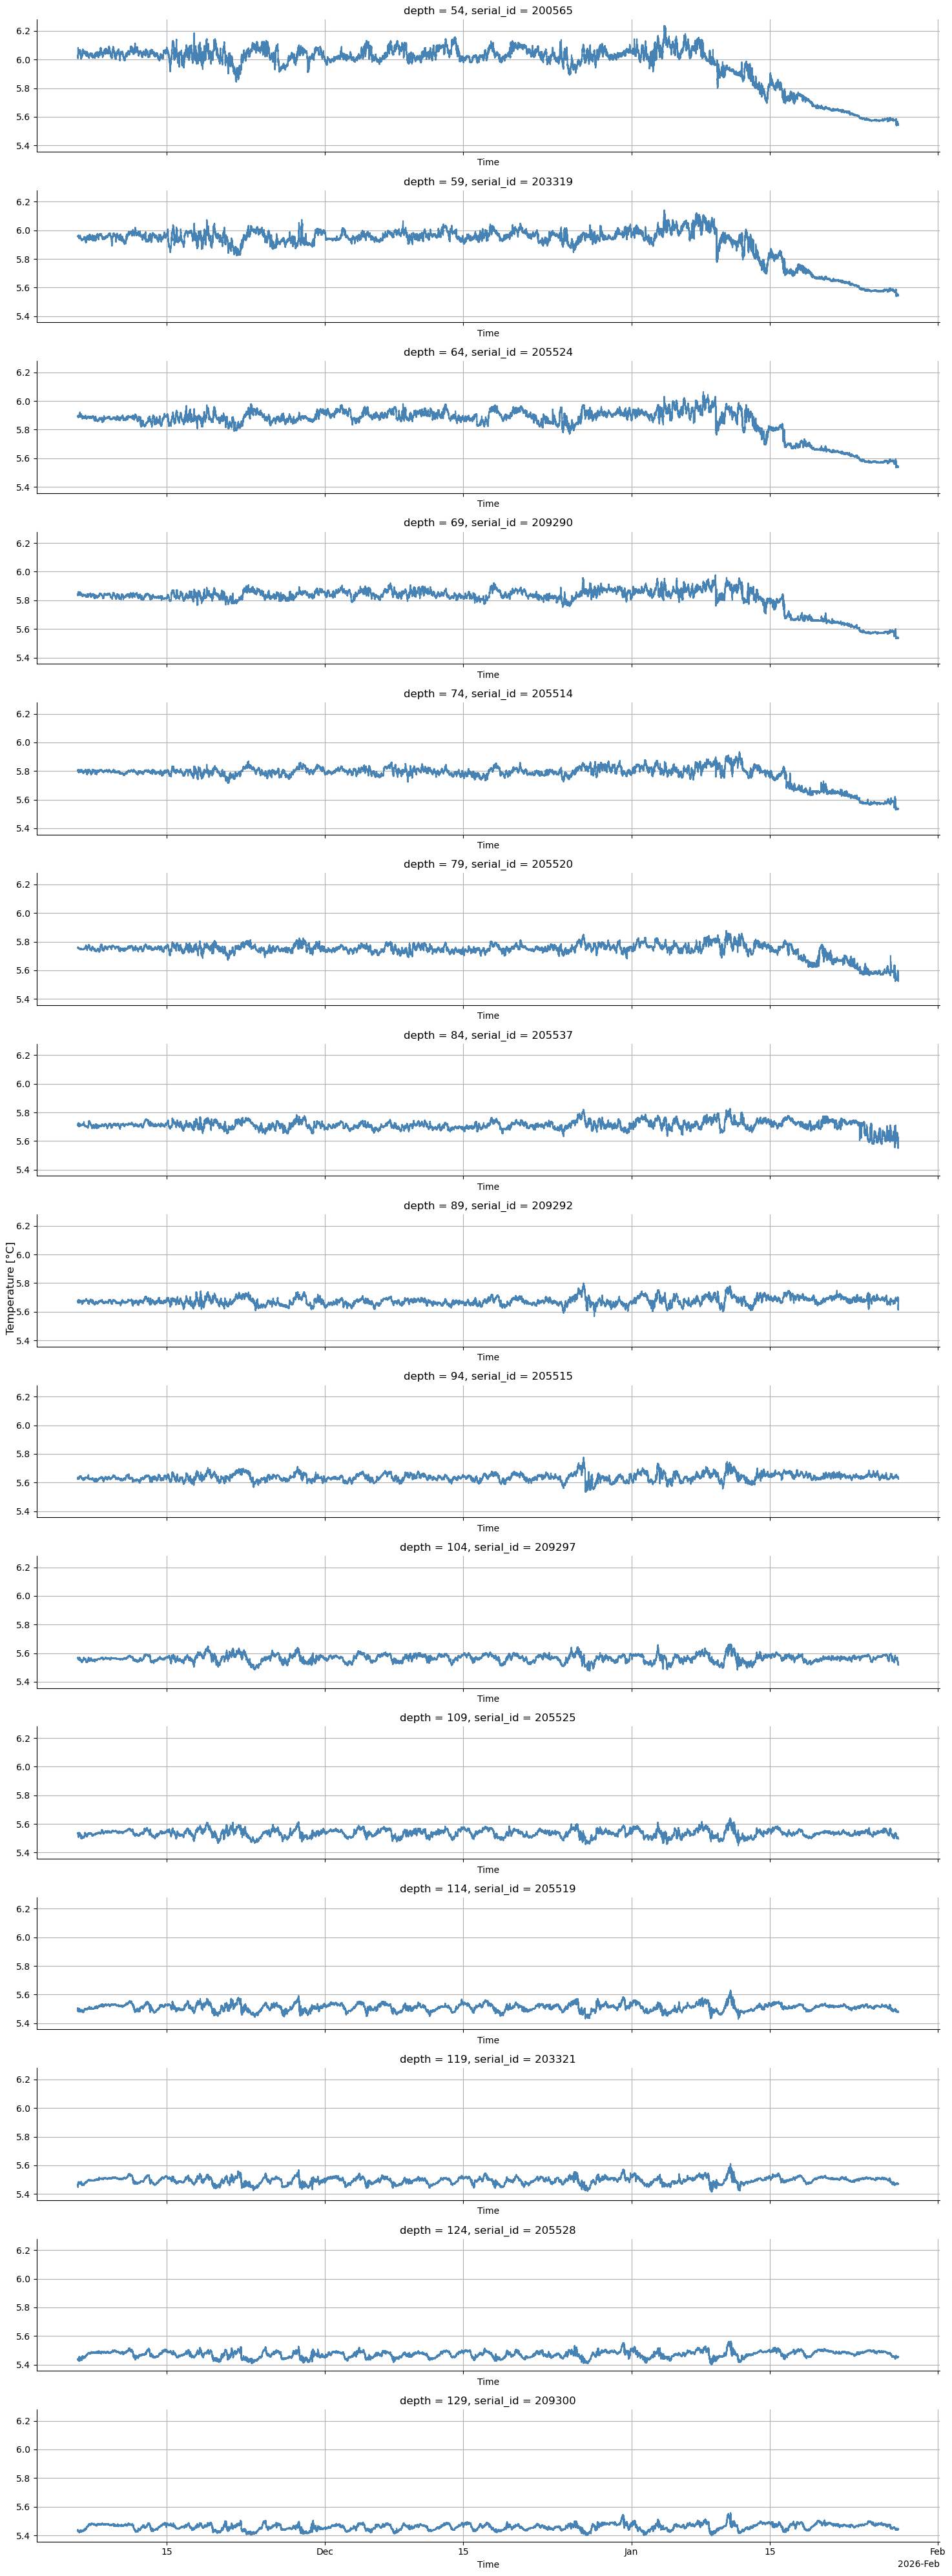

In [39]:
fig, ax = plt.subplots(nrows=len(ds_chain), ncols=1, figsize=(15, 40), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['temp'].plot(color='steelblue', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Temperature [°C]')
plt.tight_layout()
plt.show()